## Train the game prediction models
* Aggregate game-level dataframe into season-level statistics
* Compute statistics on first X% of the season, and predict games in final (100-X)% (e.g. X=70)
* Compute "advanced stats" (efficiency, effective field goal percentage, assist ratio, OReb ratio,
turnover rate) corrected for strength-of-schedule
* Engineer orthogonal features with PCA
* Try a variety of logistic regression and BDT models to predict probabilistic outcome
* Linear regressions to predict pace, total score, score margin

In [1]:
import os
import glob
from collections import defaultdict
import pickle
import gzip
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import watchcbb.utils as utils
import watchcbb.efficiency as eff
import watchcbb.sql as sql

### Load game-level dataframe

In [2]:
df = sql.df_from_query(""" SELECT * FROM game_data """)
df.head(10)

,Season,Date,gid,Type,WTeamID,WScore,LTeamID,LScore,Wrank,Lrank,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,poss
0,2011,2010-11-08,2010-11-08_california-irvine_illinois,RG,illinois,79,california-irvine,65,13,-1,...,14,22,11,26,12,14,7,1,21,74.90
1,2011,2010-11-08,2010-11-08_pittsburgh_rhode-island,RG,pittsburgh,83,rhode-island,75,5,-1,...,13,16,9,20,16,16,7,6,25,75.62
2,2011,2010-11-08,2010-11-08_maryland_seattle,RG,maryland,105,seattle,76,-1,-1,...,17,22,13,16,11,27,18,1,31,98.36
3,2011,2010-11-08,2010-11-08_navy_texas,RG,texas,83,navy,52,-1,-1,...,10,18,5,21,8,16,5,5,24,80.44
4,2011,2010-11-10,2010-11-10_college-of-charleston_maryland,RG,maryland,75,college-of-charleston,74,-1,-1,...,16,19,10,25,12,22,8,8,19,77.64
5,2011,2010-11-10,2010-11-10_illinois-chicago_pittsburgh,RG,pittsburgh,97,illinois-chicago,54,5,-1,...,7,9,5,15,9,11,0,3,18,67.88
6,2011,2010-11-10,2010-11-10_illinois_toledo,RG,illinois,84,toledo,45,13,-1,...,10,19,3,16,9,23,6,0,14,72.00
7,2011,2010-11-10,2010-11-10_louisiana-tech_texas,RG,texas,89,louisiana-tech,58,-1,-1,...,13,20,13,25,4,22,6,5,21,83.74
8,2011,2010-11-12,2010-11-12_maryland-eastern-shore_tulane,RG,tulane,91,maryland-eastern-shore,62,-1,-1,...,19,26,9,16,11,21,4,2,28,78.04
9,2011,2010-11-12,2010-11-12_marquette_prairie-view,RG,marquette,97,prairie-view,58,-1,-1,...,7,11,3,13,12,20,11,3,27,79.12


### Partition each season into two parts: one to compute statistics, and one containg games to predict

In [3]:
FRAC = 0.7
first, second = utils.partition_games(df, frac=FRAC)
print(df.iloc[first].shape[0], df.iloc[second].shape[0])

38328 16432


### Compute aggregated stats as well as some composite advanced metrics

In [4]:
fname = 'cached/gamemodel_nb_season_stats.pkl.gz'
if os.path.exists(fname):
    with gzip.open(fname, 'rb') as fid:
        season_stats_df, season_stats_dict = pickle.load(fid)
else:
    season_stats_dict = utils.compute_season_stats(df.iloc[first])
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    utils.add_advanced_stats(season_stats_df)
    season_stats_dict = utils.stats_df_to_dict(season_stats_df)
    eff.compute_efficiency_ratings(season_stats_dict)
    season_stats_df = utils.stats_dict_to_df(season_stats_dict)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    with gzip.open(fname, 'wb') as fid:
        pickle.dump((season_stats_df, season_stats_dict), fid)

print(season_stats_df.shape)
season_stats_df[['year','team_id','wins','losses','Tneteff']].head()

(3497, 85)


,year,team_id,wins,losses,Tneteff
0,2011,air-force,12,8,7.983435
1,2011,akron,12,10,-0.534660
2,2011,alabama,15,7,15.688973
3,2011,alabama-am,6,10,-15.352860
4,2011,alabama-birmingham,16,6,12.538364


### Now correct everything for strength of schedule
The Top 25 "efficiency ratings" for a certain year are printed below

In [5]:
season_stats_df[["year","team_id","Tneteff","Tcorroeff","Tcorrdeff","rawpace","pace"]]\
    .query('year==2018')\
    .sort_values('Tneteff', ascending=False).reset_index(drop=True).head(25)

,year,team_id,Tneteff,Tcorroeff,Tcorrdeff,rawpace,pace
0,2018,villanova,37.708238,129.875343,92.167105,71.399091,70.656272
1,2018,purdue,34.761396,123.531024,88.769629,70.041791,70.450607
2,2018,virginia,33.933450,114.334745,80.401295,62.175652,61.679676
3,2018,duke,33.138671,126.925882,93.787211,73.603459,74.111043
4,2018,michigan-state,32.975689,121.256876,88.281187,70.227264,69.250966
5,2018,kansas,29.033777,121.047028,92.013251,72.153913,71.695040
6,2018,cincinnati,27.969756,111.642218,83.672462,68.833636,68.380753
7,2018,texas-tech,26.201339,112.612491,86.411153,69.811613,68.836900
8,2018,tennessee,26.155361,115.796095,89.640734,68.925843,68.869876
9,2018,xavier,24.349552,120.255937,95.906384,72.955855,72.415991


### Put everything into a tidy dataframe for training models
* Randomly pick which team to use as "reference" team for relative statistics, so classes are balanced
* Add in a bunch of features that we may need for model fitting

In [6]:
data = utils.compile_training_data(df.iloc[second], season_stats_dict, sort='random', random_seed=1)
print(data.shape)
data.query("tid1=='purdue' | tid2=='purdue'").sample(frac=1, random_state=1).head(10)

(16432, 31)


,season,date,gid,tid1,tid2,result,rank1,rank2,totscore,margin,...,Oftr,Tefgp,Teff,Tftr,Otovr,neteffsum,Torbp,Oorbp,Oefgp,Oeff
10692,2017,2017-02-25,2017-02-25_michigan_purdue,purdue,michigan,0,14,-1,152,-12,...,-0.056239,0.019865,0.180004,0.020341,-0.026247,48.465058,0.056245,-0.048833,-0.060768,-9.570001
5532,2014,2014-02-23,2014-02-23_nebraska_purdue,nebraska,purdue,1,-1,-1,133,19,...,0.054069,0.032322,2.232555,0.098607,0.007570,17.951323,-0.105181,-0.043847,0.027760,0.876905
9669,2016,2016-03-12,2016-03-12_michigan_purdue,michigan,purdue,0,-1,13,135,-17,...,-0.022954,0.050062,5.833090,-0.055036,0.030464,48.334312,-0.094631,0.052396,0.072597,10.919921
12278,2018,2018-02-22,2018-02-22_illinois_purdue,illinois,purdue,0,-1,9,179,-7,...,0.215312,-0.089762,-15.700852,-0.017119,0.049764,46.064444,0.067227,0.008183,0.061917,7.757496
6167,2014,2014-03-09,2014-03-09_northwestern_purdue,northwestern,purdue,1,-1,-1,139,9,...,-0.002722,-0.006669,-8.603620,0.007175,-0.018680,12.608481,-0.165682,-0.035408,-0.026544,-4.616429
9200,2016,2016-03-01,2016-03-01_nebraska_purdue,purdue,nebraska,1,15,-1,143,19,...,-0.128661,0.020769,4.409718,0.008887,-0.031973,36.532843,0.033226,-0.062345,-0.062136,-12.478582
9028,2016,2016-02-27,2016-02-27_maryland_purdue,maryland,purdue,0,10,20,162,-4,...,-0.006775,0.042583,3.182439,0.016840,0.002991,51.510407,-0.035491,0.060311,0.018855,5.093174
13586,2019,2019-02-19,2019-02-19_indiana_purdue,indiana,purdue,0,-1,15,94,-2,...,-0.044120,-0.026265,-14.423469,0.054414,-0.024639,47.740220,-0.104259,0.011251,-0.023140,-3.561095
4752,2013,2013-03-20,2013-03-20_purdue_western-illinois,purdue,western-illinois,1,-1,-1,148,14,...,0.006509,-0.008216,1.673499,-0.046855,-0.003987,12.692052,0.141213,-0.023393,-0.024026,-0.198411
9651,2016,2016-03-11,2016-03-11_illinois_purdue,purdue,illinois,1,13,-1,147,31,...,0.015111,0.026316,6.964614,-0.007943,-0.031286,31.214605,0.152025,-0.076417,-0.098700,-15.241924


### Plot histograms of various features for winning/losing teams

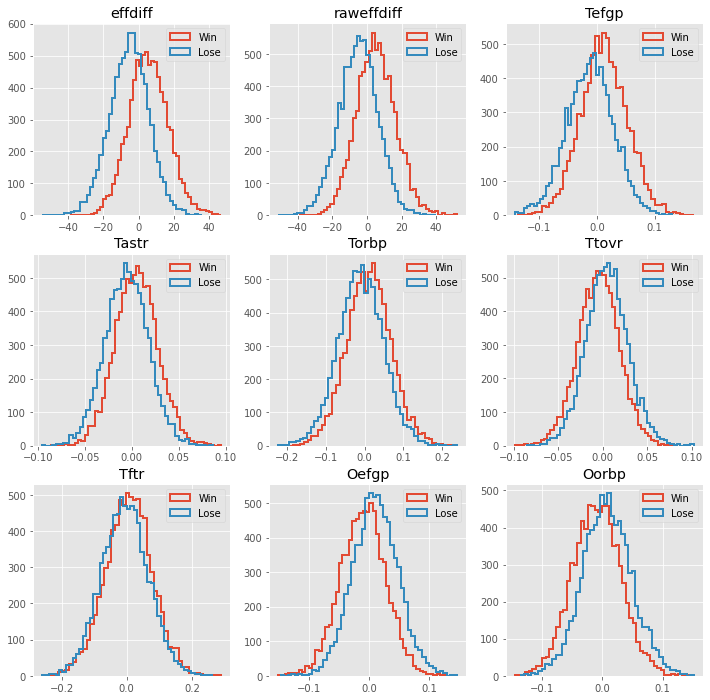

In [7]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
axs = axs.flatten()
toplot = ['effdiff','raweffdiff','Tefgp',
          'Tastr','Torbp', 'Ttovr', 
          'Tftr','Oefgp','Oorbp'
         ]
for name,ax in zip(toplot,axs):
    ax.hist(data.loc[ data.result.astype(bool)][name], bins=50, histtype='step', lw=2, label='Win')
    ax.hist(data.loc[~data.result.astype(bool)][name], bins=50, histtype='step', lw=2, label='Lose')
    ax.set_title(name)
    ax.legend()

### Various advanced stat features are highly correlated, so try running them through a PCA
Decent separation along first dimension. Even though this explains contains ~30% of the total variance,
it seems like other dimensions have relatively little discriminating power.

array([0.28958344, 0.19650012, 0.10632972, 0.09551885, 0.08297414,
       0.0628711 , 0.06212583, 0.05219973, 0.03057604, 0.01867101,
       0.00154004, 0.00110997])

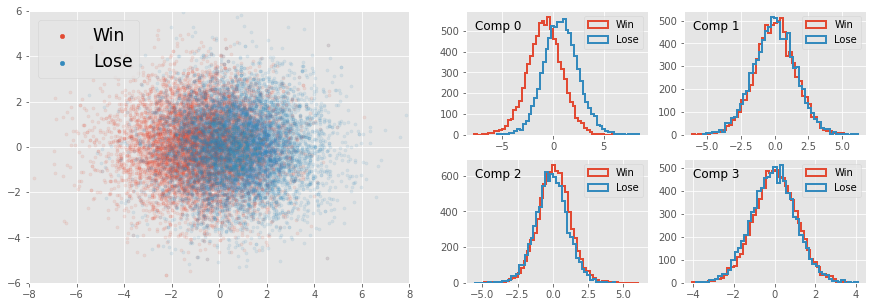

In [8]:
pca = utils.get_pca_model()

xf = pca.fit_transform(data[utils.ADVSTATFEATURES])
plt.figure(figsize=(15,5))
mask = data.result.astype(bool)
plt.subplot(1,2,1)
plt.scatter(xf[mask,0], xf[mask,1], s=10, alpha=0.1)
plt.scatter(xf[~mask,0], xf[~mask,1], s=10, alpha=0.1)
# dummy for legend
plt.scatter([100],[100],s=20, alpha=1.0, color=list(plt.rcParams['axes.prop_cycle'])[0]["color"], label="Win")
plt.scatter([100],[100],s=20, alpha=1.0, color=list(plt.rcParams['axes.prop_cycle'])[1]["color"], label="Lose")
plt.axis([-8,8,-6,6])
plt.legend(fontsize='xx-large')
for i,subplot in zip([0,1,2,3],[3,4,7,8]):
    plt.subplot(2,4,subplot)
    plt.hist(xf[mask,i], bins=50, histtype='step', lw=2, label='Win')
    plt.hist(xf[~mask,i], bins=50, histtype='step', lw=2, label='Lose')
#     plt.title('Comp '+str(i))
    plt.text(0.05,0.85,'Comp '+str(i), transform=plt.gca().transAxes, fontsize='large')
    plt.legend()
pca.named_steps['pca'].components_[0,:]
pca.named_steps['pca'].explained_variance_ratio_

### Remove two years at a time for a validation set and perform 5-fold cross validation
We try a variety of models:
* "HA" : as a baseline, a logistic regression using **only** home/away feature
* "raweffdiff" : Logistic regression using only raw efficiencies (non-SoS-corrected) and home/away. Expected to perform poorly
* "effdiff" : use SoS-corrected efficiencies
* "advstats" : Use PCA features derived above
* "advstats_xgb" : Same as above but XGBClassifier instead of logistic regression

"advstats" logistic regression with PCA values performs best in 4 out of 5 folds, and is a close second in the 5th.

LogRegPCA_AdvStats: 0.5560
LogReg_CorrEffDiff: 0.5578
XGB_AdvStats: 0.5615
LogReg_RawEffDiff: 0.5723


(0.5440107984481336, 0.59)

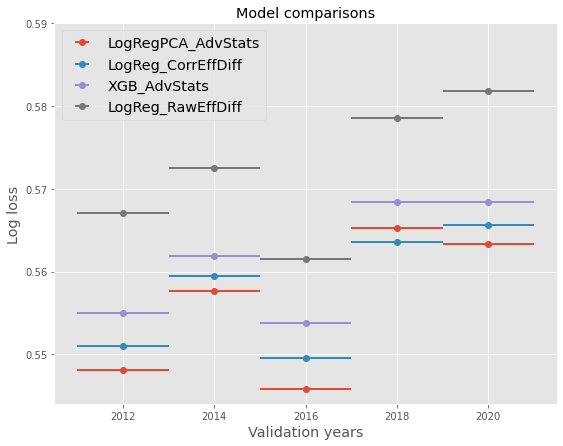

In [10]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
    
logreg = LogisticRegression(C=1.0)
xgbcls = XGBClassifier(max_depth=2, n_estimators=50)

PCAFEATURES = ["PCA"+str(i) for i in range(len(utils.ADVSTATFEATURES))]
models = {
#     "HA" : [],
    "LogReg_RawEffDiff" : ["raweffdiff"],    
    "LogReg_CorrEffDiff" : ["effdiff"],
#     "bad" : ["Otovr"],
    "LogRegPCA_AdvStats" : PCAFEATURES,
    "XGB_AdvStats" : PCAFEATURES
}

model_scores = defaultdict(list)
model_coeffs = defaultdict(list)
years = data.season.unique()
NVALID = 2
start_years = years[:len(years)-NVALID+1:NVALID]
for start_valid in start_years:
    valid_years = list(range(start_valid, start_valid+NVALID))
    train_years = sorted(set(years)-set(valid_years))
    
    data_train, data_valid = utils.train_test_split_by_year(data, train_years, valid_years, pca_model=pca)
    
    for name,features in models.items():
        X_train = data_train[features+['HA']]
        y_train = data_train.result
        X_valid = data_valid[features+['HA']]
        y_valid = data_valid.result
        
        if "xgb" not in name.lower():
            logreg.fit(X_train, y_train)
            probs = logreg.predict_proba(X_valid)
            score = log_loss(y_valid, probs)
            model_scores[name].append(score)
            model_coeffs[name].append(logreg.coef_[0,:])
        else:
            xgbcls.fit(X_train, y_train)
            probs = xgbcls.predict_proba(X_valid)
            score = log_loss(y_valid, probs)
            model_scores[name].append(score)

plt.figure(figsize=(9,7))
xs = start_years
for name,scores in sorted(model_scores.items(), key=lambda x:np.mean(x[1]), reverse=False):
    print(f'{name:10s}: {np.mean(scores):.4f}')
    plt.errorbar(xs+NVALID/2.0, scores, xerr=NVALID/2.0, fmt='o', lw=2, label=name)
plt.xlabel('Validation years', fontsize='x-large')
plt.ylabel('Log loss', fontsize='x-large')
plt.title('Model comparisons')
plt.legend(fontsize='x-large', loc='upper left');
plt.gca().set_ylim(ymax=0.59)
# model_coeffs['advstats']

### Just to make sure we didn't accidentally miss a good model, try a few XGBClassifiers over a grid of hyperparameters
Does not outperform logistic regression.

In [11]:
data_train, data_valid = utils.train_test_split_by_year(data, list(range(2011,2018)), [2018,2019,2020], pca_model=pca)

best = (0,0,0)
for i in [2,3,4]:
    for j in [10,20,50,100]:
        xgbcls = XGBClassifier(max_depth=i, n_estimators=j)
        xgbcls.fit(X_train, y_train)
        probs = xgbcls.predict_proba(X_valid)
        score = np.exp(-log_loss(y_valid, probs))
        if score > best[2]:
            best = (i,j,score)
print('(max_depth, n_estimatores, best_score)',best)

(max_depth, n_estimatores, best_score) (2, 50, 0.5663991093612312)


### Generate predictions for every game using other years as training
So we can make some pretty plots.

In [12]:
probs = []
for year in data.season.unique():
    train_years = data.season.unique().tolist()
    train_years.remove(year)
    data_train, data_valid = utils.train_test_split_by_year(data, train_years, [year], pca_model=pca)
    X_train = data_train[PCAFEATURES+['HA']]
    y_train = data_train.result
    X_valid = data_valid[PCAFEATURES+['HA']]
    
    logreg.fit(X_train, y_train)
    probs += logreg.predict_proba(X_valid)[:,1].tolist()

data["prob"] = probs

def get_upset_prob(row):
    # somewhat arbitrarily define an upset as an unranked team 
    # beating a team ranked #20 or better, or a team beating
    # a team ranked at least 10 spots higher than itself
    if (row.rank1 < 0 and 0 < row.rank2 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank1-row.rank2 > 10):
        return row.prob
    if (row.rank2 < 0 and 0 < row.rank1 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank2-row.rank1 > 10):
        return 1-row.prob
    return -1.0  

def is_upset(row):
    if (row.rank1 < 0 and 0 < row.rank2 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank1-row.rank2 > 10):
        return row.result
    if (row.rank2 < 0 and 0 < row.rank1 <= 20) or \
       (row.rank1 > 0 and row.rank2 > 0 and row.rank2-row.rank1 > 10):
        return 1-row.result
    return 0

data['upset_prob'] = data.apply(get_upset_prob, axis=1)
data['is_upset'] = data.apply(is_upset, axis=1)

data[['result','prob','rank1','rank2','upset_prob','is_upset']].head(5)

,result,prob,rank1,rank2,upset_prob,is_upset
0,1,0.696622,-1,-1,-1.000000,0
1,1,0.783395,-1,-1,-1.000000,0
2,0,0.284421,-1,14,0.284421,0
3,0,0.283433,-1,-1,-1.000000,0
4,1,0.619690,6,-1,0.380310,0


### Check model calibration by plotting observed win % in bins of predicted probability
This falls on a straight line, showing that generated probabilities are meaningful

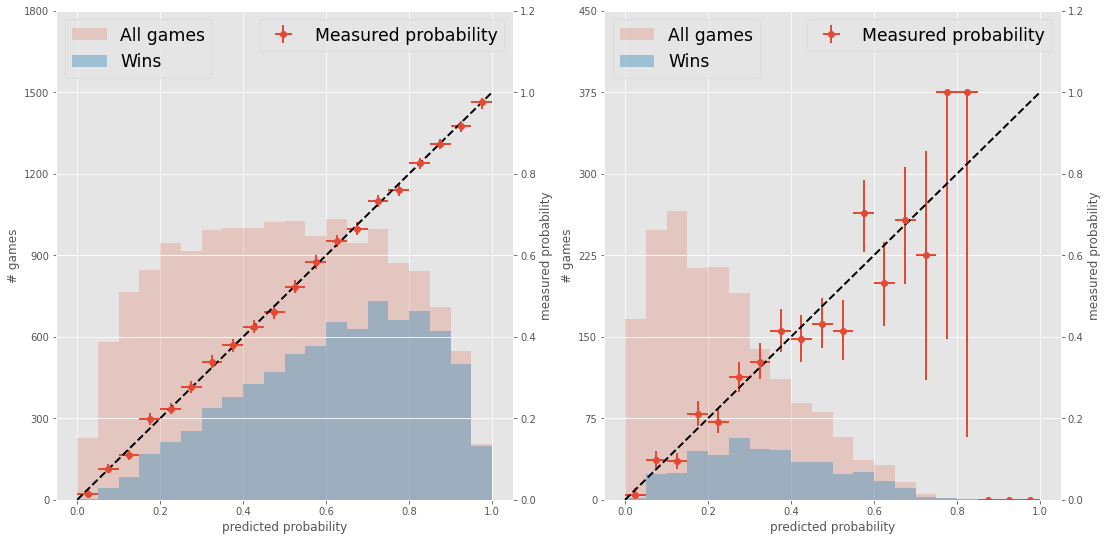

In [13]:
from statsmodels.stats.proportion import proportion_confint

binedges = np.linspace(0,1,21)

fig, axs = plt.subplots(1, 2, figsize=(18,9))
for iax, ax in enumerate(axs):
    ws = []
    errs = []
    for i in range(len(binedges)-1):
        if iax==0:
            num = ((data.prob > binedges[i]) & (data.prob < binedges[i+1]) & data.result).sum()
            den = ((data.prob > binedges[i]) & (data.prob < binedges[i+1])).sum()
        else:
            num = ((data.upset_prob > binedges[i]) & (data.upset_prob < binedges[i+1]) & data.is_upset).sum()
            den = ((data.upset_prob > binedges[i]) & (data.upset_prob < binedges[i+1])).sum()
        f = num/den if den>0 else 0
        ws.append(f)
        low, high = proportion_confint(int(num), int(den), alpha=0.31, method='beta') if den>0 else (0,0)
        errs.append([f-low, high-f])

    if iax==0:
        dens = data.prob
        nums = data.prob[data.result.astype(bool)]
    else:
        dens = data.upset_prob
        nums = data.upset_prob[data.is_upset.astype(bool)]
        
    ax.hist(dens, bins=binedges, histtype='stepfilled', lw=2, alpha=0.2, label='All games')
    ax.hist(nums, bins=binedges, histtype='stepfilled', lw=2, alpha=0.4, label='Wins')
    ax.set_xlabel('predicted probability')
    ax.set_ylabel('# games')
    ymax = 1800 if iax==0 else 450
    ax.set_ylim(0,ymax)
    ax.set_yticks(range(0,ymax+1, int(ymax/6)))
    ax.legend(loc='upper left', fontsize='xx-large')
    ax2 = ax.twinx()
    ax2.plot([0,1],[0,1],'k--',lw=2)
    ax2.errorbar(0.5*(binedges[:-1]+binedges[1:]), ws, yerr=np.array(errs).T, xerr=0.5*(binedges[1]-binedges[0]), 
                 fmt = 'o', lw=2, label='Measured probability')
    ax2.set_xlabel('predicted probability')
    ax2.set_ylabel('measured probability')
    ax2.set_ylim(0,1.2)
    ax2.legend(fontsize='xx-large')


### Perform some linear regressions to predict pace, total score, score margin

Regression for pace
[0.01468278] -1.7171342111216887
0.3039903602915236
3.812820512871874
Regression for total score
[0.00475359] 9.760462898804548
0.22433613608644287
13.779846392914086
Regression for score margin
[0.01086432 4.32542854] 0.0761184315027589
0.310831308524264
8.70667780209571


Text(0, 0.5, 'Predicted win probability')

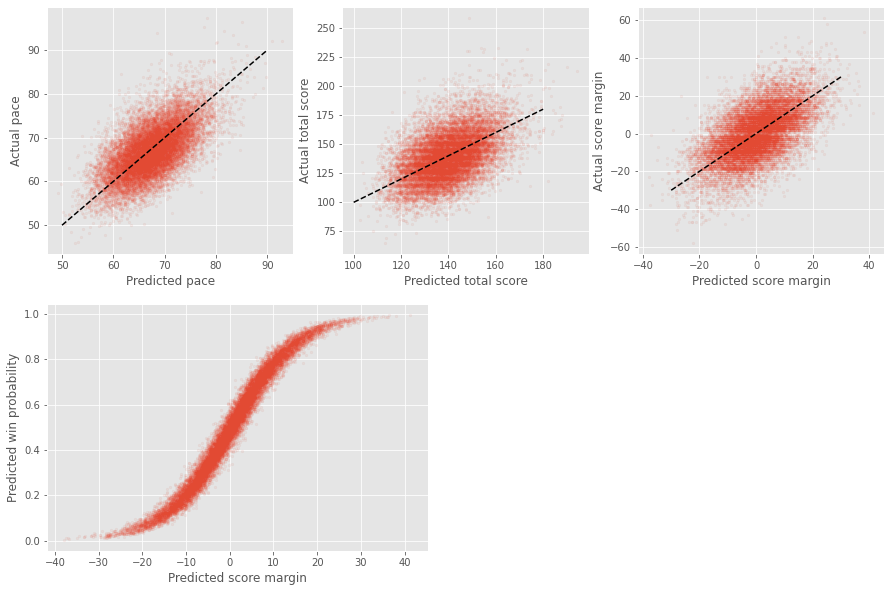

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm


linreg = LinearRegression(fit_intercept=True)

p1 = data.pace1.values
p2 = data.pace2.values
ed = data.effdiff.values
es = data.effsum.values
act_pace = data.poss.values
act_totscore = data.totscore.values
act_margin = data.margin.values

def get_weights(vals):
    # weight pace regression
    mu = vals.mean()
    std = vals.std()
    return 1/np.maximum(0.01,norm.pdf(vals, loc=mu, scale=std))

print("Regression for pace")
X = np.array([p1*p2]).T
linreg.fit(X, act_pace, get_weights(act_pace))
pred_pace = linreg.predict(X)
data["predicted_pace"] = pred_pace
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_pace))
print(mean_absolute_error(act_pace,pred_pace))

print("Regression for total score")
X = np.array([pred_pace*es]).T
linreg.fit(X, act_totscore, get_weights(act_totscore))
pred_score = linreg.predict(X)
data["predicted_totscore"] = pred_score
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_totscore))
print(mean_absolute_error(act_totscore,pred_score))

print("Regression for score margin")
X = np.array([pred_pace*ed, data.HA]).T
linreg.fit(X, act_margin, get_weights(act_margin))
pred_margin = linreg.predict(X)
data["predicted_margin"] = pred_margin
print(linreg.coef_, linreg.intercept_)
print(linreg.score(X, act_margin))
print(mean_absolute_error(act_margin,pred_margin))

plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.scatter(data.predicted_pace, data.poss, s=7, alpha=0.07)
plt.plot([50,90],[50,90],'k--')
plt.xlabel('Predicted pace')
plt.ylabel('Actual pace')
plt.subplot(2,3,2)
plt.scatter(data.predicted_totscore, data.totscore, s=7, alpha=0.07)
plt.plot([100,180],[100,180],'k--')
plt.xlabel('Predicted total score')
plt.ylabel('Actual total score')
plt.subplot(2,3,3)
plt.scatter(data.predicted_margin, data.margin, s=7, alpha=0.07)
plt.plot([-30,30],[-30,30],'k--')
plt.xlabel('Predicted score margin')
plt.ylabel('Actual score margin')
plt.subplot(2,2,3)
plt.scatter(data.predicted_margin, data.prob, s=7, alpha=0.07)
plt.xlabel("Predicted score margin")
plt.ylabel("Predicted win probability")

### Finally train on 2011-2019 for use on the 2020 season

In [16]:
data_train, data_valid = utils.train_test_split_by_year(data, range(2011,2020), [2020], pca_model=pca)
X_train = data_train[PCAFEATURES+['HA']]
y_train = data_train.result

logreg.fit(X_train, y_train)

logreg_simple = LogisticRegression()
X_train = data_train[["effdiff","HA"]]
logreg_simple.fit(X_train, y_train)

linreg_pace = LinearRegression()
linreg_margin = LinearRegression()
linreg_total = LinearRegression()


print("Regression for pace")
X_train = np.array([data_train.pace1*data_train.pace2]).T
linreg_pace.fit(X_train, data_train.poss, get_weights(data_train.poss))
# linreg_pace.fit(X_train, data_train.poss)
pred_pace_train = linreg_pace.predict(X_train)

print("Regression for score margin")
X_train = np.array([pred_pace_train*data_train.effdiff, data_train.HA]).T
linreg_margin.fit(X_train, data_train.margin)

print("Regression for total score")
X_train = np.array([pred_pace_train*data_train.effsum]).T
linreg_total.fit(X_train, data_train.totscore)

os.makedirs('../models', exist_ok=True)
with open('../models/game_regressions.pkl', 'wb') as fid:
    pickle.dump((pca, logreg, logreg_simple, linreg_pace, linreg_margin, linreg_total), fid)

Regression for pace
Regression for score margin
Regression for total score


## Plot log-loss over season with/without preseason input

In [17]:
dates = sorted(df.loc[df.Season==2020].Date.unique())
df_all = utils.get_daily_predictions(dates, df, model_file='../models/game_regressions.pkl',
                                     pickled_stats_dir='../data/season_stats/2020/')

print(df_all.shape)
df_all.head(40).tail(10)

100%|██████████| 127/127 [00:09<00:00, 13.15it/s]

(5112, 20)


,gid,result,HA,effdiff,preseason_effdiff,prob,preseason_prob,blended_prob,poss,pred_pace,pred_pace_pre,pred_pace_blend,totscore,pred_total,pred_total_pre,pred_total_blend,margin,pred_margin,pred_margin_pre,pred_margin_blend
30,2019-11-09_cal-state-fullerton_stanford,False,-1,-17.305226,-10.389,0.099389,0.171836,0.162126,71.40,74.771813,71.584380,71.936871,124,143.383914,143.355551,143.358688,-16,-14.329043,-9.635869,-10.154878
31,2019-11-09_brigham-young_san-diego-state,False,1,-11.287458,8.484,0.394460,0.792440,0.758440,70.48,78.345561,70.096077,71.008370,147,141.764125,145.795393,145.349583,-5,-4.261235,8.353482,6.958447
32,2019-11-09_arkansas-pine-bluff_gonzaga,False,-1,-39.874725,-38.708,0.004794,0.014081,0.012507,75.54,71.991713,69.520808,69.794060,170,140.418080,144.732064,144.254990,-50,-27.776963,-26.244806,-26.414244
33,2019-11-09_california-irvine_pepperdine,False,-1,16.714347,-0.760,0.636501,0.340120,0.371097,69.78,74.013615,69.331997,69.849727,150,150.679095,143.574627,144.360295,-4,7.258436,-3.742266,-2.525721
34,2019-11-09_bradley_iupui,True,1,27.431216,3.504,0.961867,0.704559,0.755829,69.58,73.393497,67.790048,68.409722,146,146.613954,140.195496,140.905300,34,20.452702,5.307232,6.982138
35,2019-11-09_central-arkansas_georgetown,False,-1,-40.337675,-21.586,0.009223,0.067185,0.054320,83.48,79.108563,73.147808,73.806995,167,158.052253,151.274103,152.023685,-11,-30.509742,-16.760059,-18.280608
36,2019-11-09_fairfield_massachusetts,False,1,-34.715578,-2.242,0.085086,0.580817,0.506849,61.26,72.295284,68.723191,69.118222,122,140.068953,143.223676,142.874802,-2,-18.124895,1.967111,-0.254822
37,2019-11-09_delaware_southern-illinois,True,0,-3.666006,-5.769,0.461483,0.360861,0.371570,62.22,69.265557,65.055853,65.521395,110,131.537598,138.531103,137.757705,2,-2.171578,-3.206836,-3.092349
38,2019-11-09_gardner-webb_western-carolina,False,-1,11.303932,-0.301,0.776094,0.349921,0.398091,73.12,75.794402,69.709547,70.382459,130,146.888266,146.338749,146.399519,-12,4.014688,-3.471810,-2.643894
39,2019-11-09_chattanooga_tennessee-state,True,1,-50.392399,5.427,0.001547,0.740933,0.554562,70.28,80.040015,68.903985,70.135495,116,157.764036,143.780548,145.326953,2,-31.120168,6.470652,2.313561


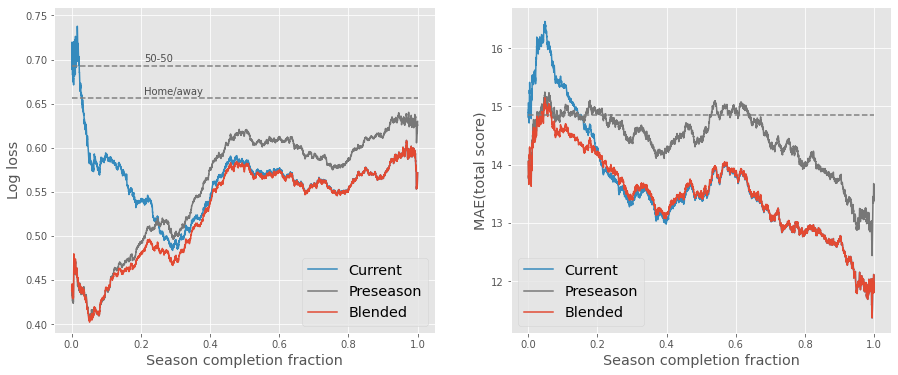

In [19]:
def moving_average_loss(y_true, y_pred, N, loss, mode='full', clip=0):
    if loss == 'logloss':
        ll = -y_true*np.log(y_pred) - (1-y_true)*np.log(1-y_pred)
    elif loss == 'mae':
        ll = np.abs(y_true - y_pred)
    elif loss == 'mse':
        ll = (y_true-y_pred)**2
    else:
        raise Exception('invalid loss ' + loss)
    
    if mode=='full':
        norm = np.convolve(np.ones(ll.size,), np.ones(N,), mode='full')
        ma = np.convolve(ll, np.ones(N,), mode='full') / norm
    elif mode=='valid':
        norm = N
        ma = np.convolve(ll, np.ones(N,), mode='valid') / norm
    else:
        raise Exception('invalid mode')
    
    if clip>0:
        ma = ma[clip:-clip]
    
    if loss == 'mse':
        ma = np.sqrt(ma)
    
    return ma

df_all.result = df_all.result.astype(int)

N = 1000
clip = 100
avg_ll_raw = moving_average_loss(df_all.result, df_all.prob, N, 'logloss', mode='full', clip=clip)
avg_ll_pre = moving_average_loss(df_all.result, df_all.preseason_prob, N, 'logloss', mode='full', clip=clip)
avg_ll_blend = moving_average_loss(df_all.result, df_all.blended_prob, N, 'logloss', mode='full', clip=clip)
avg_ae_raw = moving_average_loss(df_all.totscore, df_all.pred_total, N, 'mae', mode='full', clip=clip)
avg_ae_pre = moving_average_loss(df_all.totscore, df_all.pred_total_pre, N, 'mae', mode='full', clip=clip)
avg_ae_blend = moving_average_loss(df_all.totscore, df_all.pred_total_blend, N, 'mae', mode='full', clip=clip)


baseline_ps = {'50-50': 0.5, 
               'Home/away': (((df_all.result==1) & (df_all.HA==1)) | \
                             ((df_all.result==0) & (df_all.HA==-1))| \
                             ((df_all.result==0) & (df_all.HA==0))).mean()
              }
baseline_mae = np.mean(np.abs(df_all.totscore - df_all.totscore.mean()))

fig,axs = plt.subplots(1,2,figsize=(15,6))
# fig,axs = plt.subplots(1,1,figsize=(8,6))
# axs = [axs]
axs[0].plot(np.linspace(0,1,avg_ll_raw.size), avg_ll_raw, label="Current", color=list(plt.rcParams['axes.prop_cycle'])[1]['color'])
axs[0].plot(np.linspace(0,1,avg_ll_pre.size), avg_ll_pre, label="Preseason", color=list(plt.rcParams['axes.prop_cycle'])[3]['color'])
axs[0].plot(np.linspace(0,1,avg_ll_blend.size), avg_ll_blend, label="Blended", color=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
for s,p in baseline_ps.items():
    p = -p*np.log(p) - (1-p)*np.log(1-p)
    axs[0].plot([0,1], [p]*2, '--', color='0.5')
    axs[0].text(0.21, p+0.005, s, color='0.3')
axs[0].set_xlabel('Season completion fraction', fontsize='x-large')
axs[0].set_ylabel('Log loss', fontsize='x-large')
# plt.gca().set_ylim(ymin=0)
axs[0].legend(fontsize='x-large', loc='lower right')
axs[0].set_ylim(0.39,0.76)

axs[1].plot(np.linspace(0,1,avg_ae_raw.size), avg_ae_raw, label="Current", color=list(plt.rcParams['axes.prop_cycle'])[1]['color'])
axs[1].plot(np.linspace(0,1,avg_ae_pre.size), avg_ae_pre, label="Preseason", color=list(plt.rcParams['axes.prop_cycle'])[3]['color'])
axs[1].plot(np.linspace(0,1,avg_ae_blend.size), avg_ae_blend, label="Blended", color=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
axs[1].plot([0,1], [baseline_mae]*2, '--', color='0.5')
axs[1].set_xlabel('Season completion fraction', fontsize='x-large')
axs[1].set_ylabel('MAE(total score)', fontsize='x-large')
axs[1].legend(fontsize='x-large', loc='lower left')

## Arbitrarily divide pace outputs into quintiles and get confusion matrix

Thresholds: [  61.9794424    65.29636072   71.93019736   75.24711568 9999.        ]
Accuracy (exact quintile, +-1 quintile): 0.473 0.878
[[  39  121  242   10    0]
 [  11  137  609   50    0]
 [   6  130 1747  418   87]
 [   0   10  454  282   87]
 [   0    1  216  242  213]]
[[0.69642857 0.19642857 0.10714286 0.         0.        ]
 [0.30325815 0.3433584  0.32581454 0.02506266 0.00250627]
 [0.07405141 0.18635251 0.53457772 0.13892289 0.06609547]
 [0.00998004 0.0499002  0.41716567 0.28143713 0.24151697]
 [0.         0.         0.2248062  0.2248062  0.5503876 ]]


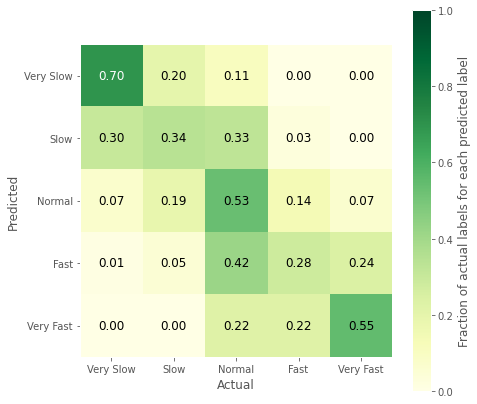

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

paces = df_all[['gid','poss','pred_pace','pred_pace_blend']].copy()
mean = season_stats_df.pace.mean()
std = season_stats_df.pace.std()
thresh = np.array([mean-2*std, mean-1*std, mean+1*std, mean+2*std, 9999])
# thresh = np.append(np.percentile(paces.poss, [20,40,60,80]), [9999])
print("Thresholds:", thresh)
c, p, pb = [], [], []
for irow,row in paces.iterrows():
    c.append(np.argmax(thresh>=row.poss))
    p.append(np.argmax(thresh>=row.pred_pace))
    pb.append(np.argmax(thresh>=row.pred_pace_blend))
paces['c'] = c
paces['p'] = p
paces['pb'] = pb
print("Accuracy (exact quintile, +-1 quintile): {0:.3f} {1:.3f}".format(
    np.mean(np.abs(paces.c - paces.pb)<=0), np.mean(np.abs(paces.c - paces.pb)<=1)))
cm = confusion_matrix(paces.c, paces.pb)
print(cm)
cm = (cm/cm.sum(axis=0)).T
print(cm)
plt.figure(figsize=(7,7))
plt.imshow(cm, cmap='YlGn', vmin=0, vmax=1)
plt.yticks([0,1,2,3,4],['Very Slow','Slow','Normal','Fast','Very Fast'])
plt.xticks([0,1,2,3,4],['Very Slow','Slow','Normal','Fast','Very Fast'])
plt.ylabel('Predicted')
plt.xlabel('Actual')
for i in range(5):
    for j in range(5):
        c = 'k' if cm[j,i] < 0.6 else 'w'
        plt.text(i, j, '{:.2f}'.format(cm[j,i]), ha='center', va='center', color=c, fontsize='large')
cb = plt.colorbar()
cb.set_label('Fraction of actual labels for each predicted label')
plt.grid(False)

## See how we compare to ESPN's predictions

In [22]:
dfs = []
for f in sorted(glob.glob('../data/espn_preds/*.txt')):
    dfs.append(pd.read_csv(f, names=['date','tid1','tid2','prob','line']))
df_espn = pd.concat(dfs)
def get_gid(row):
    tid1, tid2 = sorted((row.tid1,row.tid2))
    return '{0}_{1}_{2}'.format(row.date, tid1, tid2)
df_espn['gid'] = df_espn.apply(get_gid, axis=1)
df_espn['prob'] = df_espn.apply(lambda row: 1-row.prob if row.tid1<row.tid2 else row.prob, axis=1)
df_espn.head()

,date,tid1,tid2,prob,line,gid
0,2019-11-05,michigan-state,kentucky,0.403,-2.5,2019-11-05_kentucky_michigan-state
1,2019-11-05,kansas,duke,0.617,3.2,2019-11-05_duke_kansas
2,2019-11-05,louisville,miami-fl,0.404,2.5,2019-11-05_louisville_miami-fl
3,2019-11-05,saint-marys-ca,wisconsin,0.285,5.2,2019-11-05_saint-marys-ca_wisconsin
4,2019-11-05,georgia-tech,north-carolina-state,0.171,10.3,2019-11-05_georgia-tech_north-carolina-state


In [23]:
df_comp = df_all[['gid','result','blended_prob','pred_margin_blend']].merge(
    df_espn[['gid','prob','line']], on='gid', how='inner')
df_comp.rename({'blended_prob':'my_prob','pred_margin_blend':'my_line',
                'prob':'espn_prob','line':'espn_line'}, axis=1, inplace=True)
print(df_comp.shape)
df_comp.head()

(5081, 6)


,gid,result,my_prob,my_line,espn_prob,espn_line
0,2019-11-08_houston-baptist_oral-roberts,0,0.231850,-7.154510,0.320,5.8
1,2019-11-08_incarnate-word_northern-colorado,0,0.081324,-14.210288,0.039,22.1
2,2019-11-08_kansas_north-carolina-greensboro,1,0.897801,13.651281,0.872,13.1
3,2019-11-08_long-island-university_massachusett...,0,0.656814,4.033920,0.609,3.1
4,2019-11-08_siena_xavier,0,0.050287,-16.690287,0.046,19.5


Text(0, 0.5, 'Log loss')

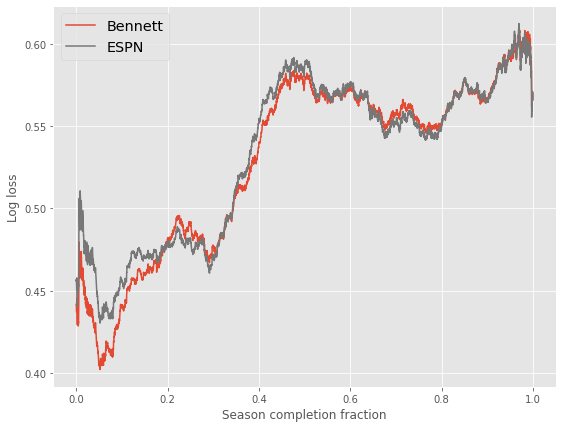

In [24]:
N = 1000
clip = 100
ll_mine = moving_average_loss(df_comp.result, df_comp.my_prob, N, 'logloss', mode='full', clip=clip)
ll_espn = moving_average_loss(df_comp.result, df_comp.espn_prob, N, 'logloss', mode='full', clip=clip)

plt.figure(figsize=(9,7))
xs = np.linspace(0, 1, ll_mine.size)
plt.plot(xs, ll_mine, label='Bennett', color=list(plt.rcParams['axes.prop_cycle'])[0]['color'])
plt.plot(xs, ll_espn, label='ESPN', color=list(plt.rcParams['axes.prop_cycle'])[3]['color'])
# plt.plot(xs, ll_espn-ll_mine, label='Difference')
plt.legend(fontsize='x-large')
plt.xlabel("Season completion fraction")
plt.ylabel("Log loss")